# Sentiment analysis media cloud extrated data

This notebook implements a foundational Sentiment Analysis pipeline on news titles, addressing the constraint of no labeled training data. We use the VADER lexicon method for classification and demonstrate feature engineering using TF-IDF and Truncated SVD (LSA) for future-proofing and exploration.

In [2]:
# Core Libraries
import pandas as pd
import re

# Sentiment Analysis (Lexicon)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Feature Extraction and Dimensionality Reduction (ML components)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# --- Sample Newspaper Titles Data ---
media_cloud = pd.read_csv("data/mediacloud-2020-2025-dataset.csv") 
media_cloud.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f129...,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senato...,https://techcrunch.com/2025/11/02/google-pulls...
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7b...,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss...,https://www.livemint.com/opinion/online-views/...
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522c...,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI s...,https://apnews.com/article/openai-safety-chatg...
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8...,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su l...",https://www.infolibre.es/politica/chatgpt-rect...
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795c...,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a ...",https://www.thestar.com/business/opinion/like-...


In [4]:
#since the dataset has not been tranlated we will filter for only english titles
media_cloud = media_cloud[media_cloud['language'] == 'en']

In [5]:
#let's conduct a sanity check on the data
print(media_cloud["language"].value_counts())

language
en    28928
Name: count, dtype: int64


# Preprocessing and Text Cleaning

In [6]:
def clean_text(text):
    # 1. Lowercasing (Standard practice for normalization)
    text = text.lower()
    # 2. Remove text inside parentheses (often non-essential context in titles)
    text = re.sub(r'\([^)]*\)', '', text)
    # 3. Remove most punctuation, but KEEP VADER-relevant symbols (like ! and ?)
    # VADER is explicitly designed to use punctuation (!!!) and capitalization (ALL CAPS)
    # as intensifiers. We will clean for the *TF-IDF* features but keep the raw
    # title for VADER, which is why we create a separate 'Clean_Title' column.
    return text

# We will create a clean version for feature extraction (TF-IDF)
media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)


# Core Sentiment Classification (Lexicon-Based)

In [7]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    # Use the ORIGINAL 'Title' for VADER to leverage capitalization and punctuation
    return analyzer.polarity_scores(text)['compound']

def classify_sentiment(score):
    # Standard VADER thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

media_cloud['VADER_Compound_Score'] = media_cloud['title'].apply(get_vader_sentiment)
media_cloud['Sentiment_VADER'] = media_cloud['VADER_Compound_Score'].apply(classify_sentiment)

print("--- Sentiment Analysis Results (VADER) ---")
print(media_cloud[['title', 'VADER_Compound_Score', 'Sentiment_VADER']])

--- Sentiment Analysis Results (VADER) ---
                                                   title  \
0      Google pulls Gemma from AI Studio after Senato...   
1      Here's why India’s AI content draft rules miss...   
2      Who is Zico Kolter? A professor leads OpenAI s...   
4      Like maple syrup and hockey, AI must become a ...   
5      The professor leading OpenAI's safety panel ma...   
...                                                  ...   
35392  AI emerges as new tool for online scammers: Su...   
35393     Dealing with deepfakes: Regulation & education   
35394  New Delhi Slush’D witnessed unprecedented succ...   
35395                           AI on human rights watch   
35397  Musk ‘sensationalist’ comments on AI taking jo...   

       VADER_Compound_Score Sentiment_VADER  
0                   -0.3400        Negative  
1                   -0.1531        Negative  
2                    0.4215        Positive  
4                    0.3612        Positive  
5     

# Post-Classification Exploration and Feature Engineering

In [8]:
# Vectorize the CLEANED text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(media_cloud['clean_title'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Vectorization Complete.")
print(f"Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): {tfidf_matrix.shape}")

TF-IDF Vectorization Complete.
Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): (28928, 124260)


In [9]:
# Reduce dimensions to 2 components for ease of inspection
svd = TruncatedSVD(n_components=2, random_state=42)
lsa_result = svd.fit_transform(tfidf_matrix)

media_cloud['LSA_Component_1'] = lsa_result[:, 0]
media_cloud['LSA_Component_2'] = lsa_result[:, 1]

print("\n--- Exploration: LSA Components and Sentiment ---")
print(media_cloud[['Sentiment_VADER', 'LSA_Component_1', 'LSA_Component_2']])

# Look at the top features that define the discovered LSA components (the 'topics')
print("\nTop features defining the LSA Components (Inferred Topics):")
for i, comp in enumerate(svd.components_):
    # Get the top 5 words/n-grams that contribute most to this component
    sorted_idx = comp.argsort()[::-1][:5]
    top_words = [feature_names[j] for j in sorted_idx]
    print(f"Component {i+1}: {top_words}")


--- Exploration: LSA Components and Sentiment ---
      Sentiment_VADER  LSA_Component_1  LSA_Component_2
0            Negative         0.030815        -0.012733
1            Negative         0.055968        -0.016886
2            Positive         0.064913        -0.032610
4            Positive         0.032555        -0.013505
5            Positive         0.068994        -0.027918
...               ...              ...              ...
35392         Neutral         0.048279        -0.016797
35393         Neutral         0.032481        -0.013578
35394        Positive         0.018187        -0.003900
35395         Neutral         0.061244        -0.017238
35397         Neutral         0.051768        -0.020572

[28928 rows x 3 columns]

Top features defining the LSA Components (Inferred Topics):
Component 1: ['ai', 'safety', 'intelligence', 'artificial', 'artificial intelligence']
Component 2: ['artificial', 'intelligence', 'artificial intelligence', 'regulate artificial', 'extincti

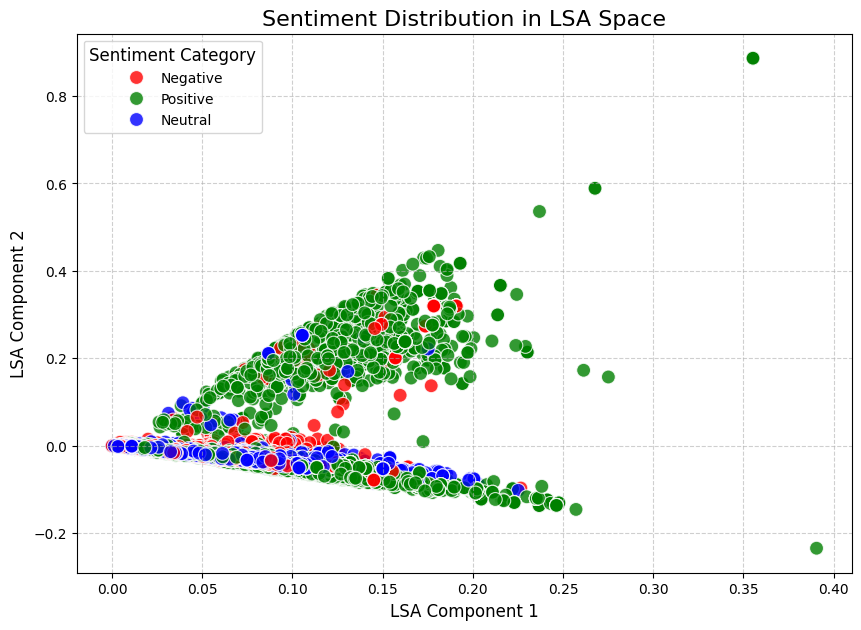

In [10]:
# 3. Visualization of LSA Components by Sentiment
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='LSA_Component_1',
    y='LSA_Component_2',
    hue='Sentiment_VADER',  # Color points by sentiment
    data=media_cloud,
    s=100, # Size of points
    alpha=0.8, # Transparency
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'} # Custom colors
)

# Add titles for clarity
plt.title('Sentiment Distribution in LSA Space', fontsize=16)
plt.xlabel('LSA Component 1', fontsize=12)
plt.ylabel('LSA Component 2', fontsize=12)

# Ensure the legend is displayed clearly
plt.legend(title='Sentiment Category', title_fontsize='12', fontsize='10')

plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [11]:
# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['Sentiment_VADER'] = media_cloud['Sentiment_VADER'].values

# Group by sentiment and compute mean TF-IDF scores
grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()

In [12]:
for sentiment in grouped_tfidf.index:
    top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\nTop TF-IDF words for {sentiment} sentiment:")
    print(top_words)



Top TF-IDF words for Negative sentiment:
ai         0.030776
risks      0.009628
openai     0.009117
risk       0.008292
warns      0.008277
tech       0.007161
eu         0.006700
chatgpt    0.006522
musk       0.006163
ban        0.006143
Name: Negative, dtype: float64

Top TF-IDF words for Neutral sentiment:
ai               0.032902
tech             0.008707
openai           0.008552
new              0.008517
regulation       0.007737
eu               0.007705
musk             0.006393
ai regulation    0.006190
trump            0.006025
says             0.006021
Name: Neutral, dtype: float64

Top TF-IDF words for Positive sentiment:
ai                         0.032795
safety                     0.018256
intelligence               0.016792
artificial                 0.016239
artificial intelligence    0.016026
ai safety                  0.014064
tech                       0.008075
summit                     0.007601
new                        0.007407
uk                         0.0

# Let's see how this results change according to each year

we first create different datasets where the filter is the year

and we do the same analysis done above

In [14]:
media_cloud['publish_date'] = pd.to_datetime(media_cloud.get('publish_date', media_cloud.get('date', None)), errors='coerce')
media_cloud['year'] = media_cloud['publish_date'].dt.year


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


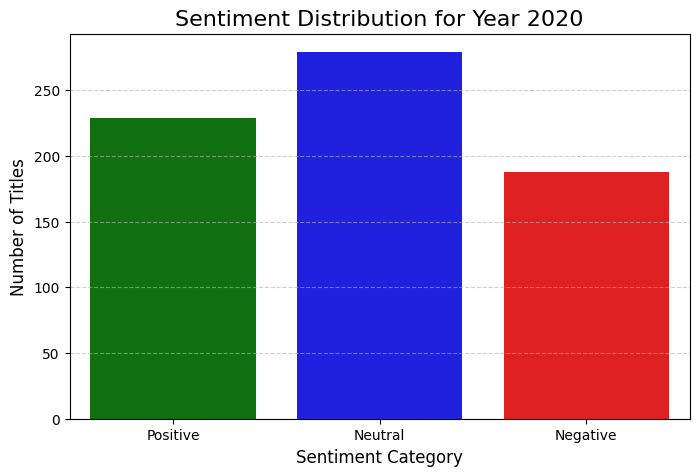


Year 2020 - Top TF-IDF words for Negative sentiment:
trump                0.030973
coronavirus          0.026140
facebook             0.022916
rules hate           0.017205
eu threatens         0.017205
tougher rules        0.017048
hate speech          0.016903
rules                0.016166
threatens tougher    0.015984
speech facebook      0.015824
Name: Negative, dtype: float64

Year 2020 - Top TF-IDF words for Neutral sentiment:
trump                0.020226
ai                   0.018468
democratic           0.016883
democratic debate    0.016641
google               0.015796
debate               0.015281
watch                0.015204
regulation           0.014802
ai regulation        0.013351
impeachment          0.012108
Name: Neutral, dtype: float64

Year 2020 - Top TF-IDF words for Positive sentiment:
artificial                 0.028060
intelligence               0.027793
artificial intelligence    0.027742
ai                         0.019838
2020                       0.01246

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


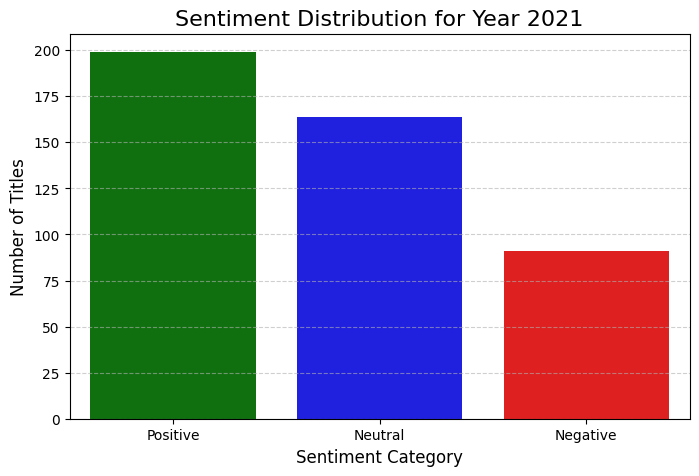


Year 2021 - Top TF-IDF words for Negative sentiment:
ban              0.032806
eu               0.031782
rules            0.028120
ai               0.026325
brother fears    0.024631
big brother      0.024033
brother          0.024033
ai rules         0.023623
rules ban        0.022475
temper big       0.021666
Name: Negative, dtype: float64

Year 2021 - Top TF-IDF words for Neutral sentiment:
ai                 0.028331
strategy           0.015717
tech               0.015545
national           0.015096
ai synthetic       0.014576
synthetic media    0.014576
eu                 0.014445
perilous phase     0.014407
enters perilous    0.014407
tech enters        0.014407
Name: Neutral, dtype: float64

Year 2021 - Top TF-IDF words for Positive sentiment:
ai                         0.026599
intelligence               0.023885
artificial intelligence    0.023748
artificial                 0.023569
2021                       0.018380
urges boost                0.017620
panel urges           

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


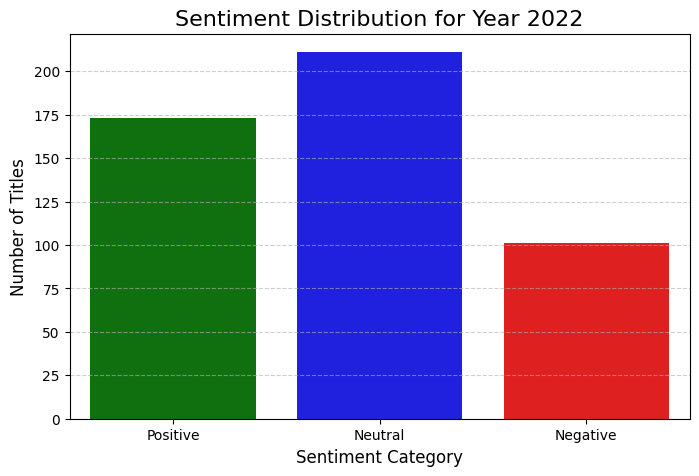


Year 2022 - Top TF-IDF words for Negative sentiment:
ai           0.033881
ai ethics    0.020920
ethics       0.018776
collapse     0.014898
liable ai    0.014613
liable       0.014283
eu           0.014061
looming      0.012091
crypto       0.011721
systems      0.011079
Name: Negative, dtype: float64

Year 2022 - Top TF-IDF words for Neutral sentiment:
ai                 0.032407
ai rises           0.025922
lawmakers try      0.025371
try catch          0.025371
rises lawmakers    0.025207
rises              0.024258
try                0.022701
catch              0.021303
lawmakers          0.016576
ai ethics          0.014025
Name: Neutral, dtype: float64

Year 2022 - Top TF-IDF words for Positive sentiment:
ai                         0.032206
intelligence               0.026937
artificial intelligence    0.026864
artificial                 0.026662
ai ethics                  0.015268
ethics                     0.014932
data                       0.012397
ethics ai                 

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


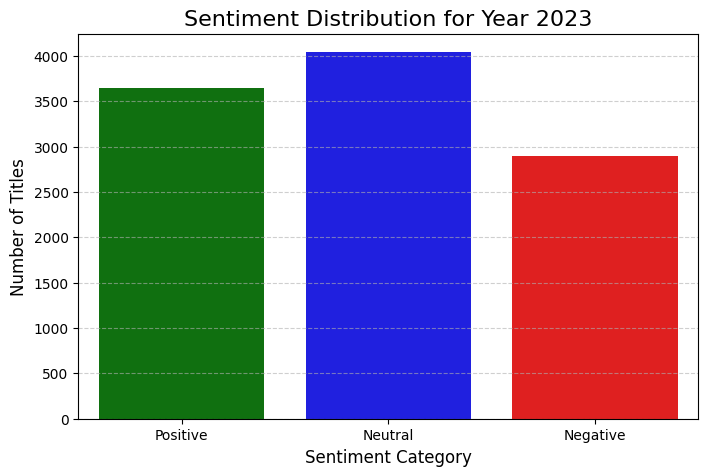


Year 2023 - Top TF-IDF words for Negative sentiment:
ai            0.031165
risks         0.012792
risk          0.012092
warns         0.012083
openai        0.011978
chatgpt       0.011338
extinction    0.010696
experts       0.008445
altman        0.008274
eu            0.007992
Name: Negative, dtype: float64

Year 2023 - Top TF-IDF words for Neutral sentiment:
ai            0.033687
openai        0.013098
musk          0.012473
regulation    0.010475
chatgpt       0.010190
eu            0.009441
tech          0.009159
elon          0.008928
elon musk     0.008868
regulate      0.008759
Name: Neutral, dtype: float64

Year 2023 - Top TF-IDF words for Positive sentiment:
ai                         0.033245
artificial                 0.022189
intelligence               0.022148
artificial intelligence    0.022140
safety                     0.020191
ai safety                  0.017094
summit                     0.013358
uk                         0.010900
safety summit              0.0

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


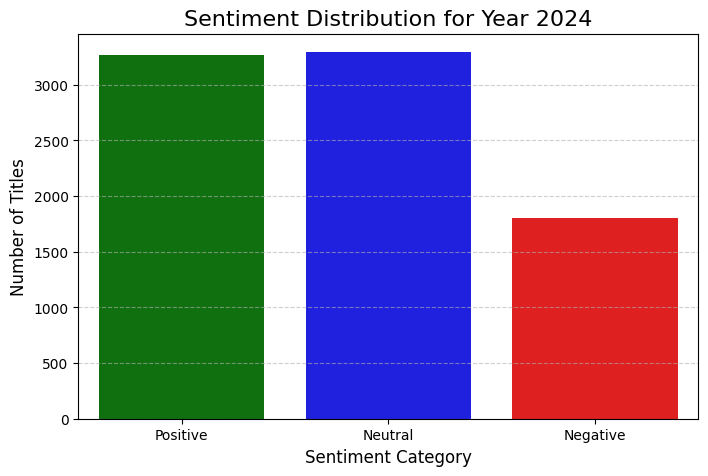


Year 2024 - Top TF-IDF words for Negative sentiment:
ai          0.029461
openai      0.010248
risks       0.009764
election    0.007428
risk        0.006932
tech        0.006847
musk        0.006816
says        0.006720
ai risks    0.006346
google      0.006128
Name: Negative, dtype: float64

Year 2024 - Top TF-IDF words for Neutral sentiment:
ai            0.032188
2024          0.017101
tech          0.008793
openai        0.008343
new           0.008241
eu            0.007728
trump         0.006782
regulation    0.005844
december      0.005027
policy        0.004988
Name: Neutral, dtype: float64

Year 2024 - Top TF-IDF words for Positive sentiment:
ai                         0.033772
safety                     0.023993
ai safety                  0.017938
intelligence               0.015028
artificial                 0.014256
artificial intelligence    0.013982
new                        0.009891
openai                     0.008863
tech                       0.007597
california    

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_51731/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


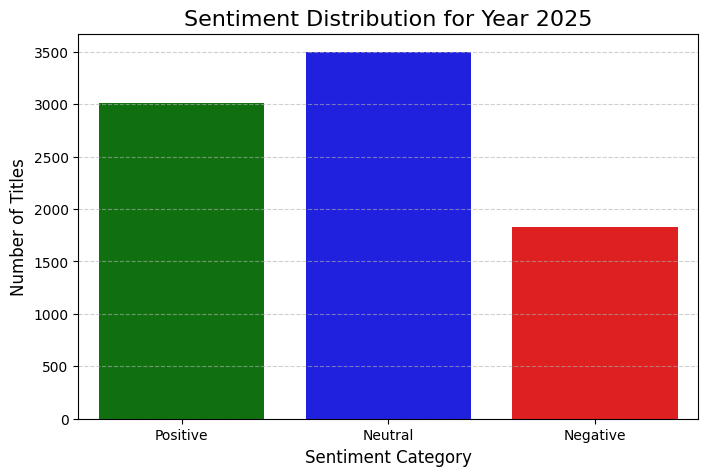


Year 2025 - Top TF-IDF words for Negative sentiment:
ai            0.033675
trump         0.013632
ban           0.011807
senate        0.007277
tech          0.007170
warns         0.006725
new           0.006607
regulation    0.006547
state         0.006363
risks         0.006171
Name: Negative, dtype: float64

Year 2025 - Top TF-IDF words for Neutral sentiment:
ai            0.034062
trump         0.011146
2025          0.010742
new           0.009015
tech          0.008119
regulation    0.006216
global        0.006176
policy        0.006110
eu            0.005733
china         0.005679
Name: Neutral, dtype: float64

Year 2025 - Top TF-IDF words for Positive sentiment:
ai                         0.032619
safety                     0.012308
intelligence               0.010332
artificial                 0.009203
innovation                 0.009072
artificial intelligence    0.008816
trump                      0.008803
ai safety                  0.008637
new                        0.0

In [16]:
# ...existing code...
import numpy as np

for year in sorted(media_cloud['year'].dropna().unique()):
    yearly_data = media_cloud[media_cloud['year'] == year]
    if yearly_data.empty:
        continue

    # distribution plot
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],
                  palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'})
    plt.title(f'Sentiment Distribution for Year {year}', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Number of Titles', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # transform YEARLY cleaned titles (do NOT refit vectorizer)
    yearly_tfidf = vectorizer.transform(yearly_data['clean_title'])  # sparse matrix (n_titles x n_features)

    # compute mean TF-IDF per sentiment (sparse-safe)
    if yearly_tfidf.shape[0] <= 5000:
        tfidf_df = pd.DataFrame(yearly_tfidf.toarray(), columns=feature_names, index=yearly_data.index)
        tfidf_df['Sentiment_VADER'] = yearly_data['Sentiment_VADER'].values
        grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()
    else:
        grouped = {}
        # .groups returns mapping sentiment -> list of index labels in yearly_data
        for sentiment, idx_labels in yearly_data.groupby('Sentiment_VADER').groups.items():
            pos = yearly_data.index.get_indexer(list(idx_labels))  # positions relative to yearly_tfidf rows
            sub = yearly_tfidf[pos]
            mean_vec = sub.mean(axis=0)
            grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
        grouped_tfidf = pd.DataFrame(grouped).T

    # print top words per sentiment for this year
    for sentiment in grouped_tfidf.index:
        top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
        print(f"\nYear {year} - Top TF-IDF words for {sentiment} sentiment:")
        print(top_words)
# ...existing code...

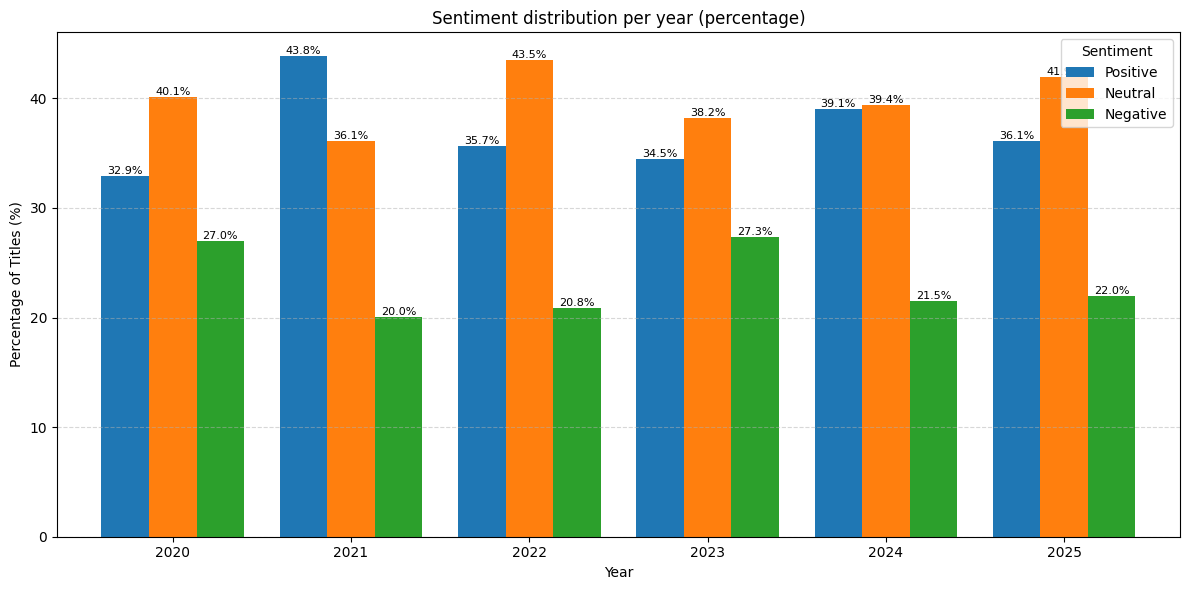

In [20]:
import numpy as np

# ensure desired sentiment order
sentiments_order = ['Positive', 'Neutral', 'Negative']

# compute counts per year x sentiment and convert to percentages per year
counts = media_cloud.groupby(['year', 'Sentiment_VADER']).size().unstack(fill_value=0)
counts = counts.reindex(columns=sentiments_order, fill_value=0)  # enforce column order
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100  # percent per year

# plot grouped bars (each year has three bars: Positive, Neutral, Negative)
ax = counts_pct.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'] )
ax.set_ylabel('Percentage of Titles (%)')
ax.set_xlabel('Year')
ax.set_title('Sentiment distribution per year (percentage)')
ax.legend(title='Sentiment', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

# annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()
